1. 계통추출(test set 추출)  
2. 3번 이하, 4번이하 빈도수 단어들로 구분지어 실행해보기 → 단어 몇 개 정도 남길건지 결정
ex. 5000개 가지고 train 했을 경우의 정확도

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('DS01.csv')
data

,발화,감정_int
0,언니 동생으로 부르는게 맞는 일인가요..??,0
1,그냥 내 느낌일뿐겠지?,0
2,아직너무초기라서 그런거죠?,0
3,유치원버스 사고 낫다던데,0
4,근데 원래이런거맞나요,0
...,...,...
14129,"봐봐, 이거 너무 복실복실하지?",1
14130,"하긴 남자애니까. 별로 관심 없으려나? 그래도 여기 남성 의류 말야, 평판이 꽤 좋...",1
14131,이럴 땐 진짜 질색하는 표정이 된다니깐. 감탄스럽기까지 해.,1
14132,"너무 대놓고 그러면 역효과잖니? 난 지금 이대로면 충분한걸. ……하긴, 옛날엔 페어...",1


In [3]:
 data['발화'].nunique(), data['감정_int'].nunique()

(14075, 2)

In [4]:
data.isnull().sum()

발화        0
감정_int    0
dtype: int64

In [5]:
data.drop_duplicates(subset = ["발화"], inplace = True)
data

,발화,감정_int
0,언니 동생으로 부르는게 맞는 일인가요..??,0
1,그냥 내 느낌일뿐겠지?,0
2,아직너무초기라서 그런거죠?,0
3,유치원버스 사고 낫다던데,0
4,근데 원래이런거맞나요,0
...,...,...
14129,"봐봐, 이거 너무 복실복실하지?",1
14130,"하긴 남자애니까. 별로 관심 없으려나? 그래도 여기 남성 의류 말야, 평판이 꽤 좋...",1
14131,이럴 땐 진짜 질색하는 표정이 된다니깐. 감탄스럽기까지 해.,1
14132,"너무 대놓고 그러면 역효과잖니? 난 지금 이대로면 충분한걸. ……하긴, 옛날엔 페어...",1


In [6]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x1ec31fd2520>)

In [7]:
shop_data = pd.read_table('ratings_total.txt', names=['ratings', '발화'])
print('전체 리뷰 개수 :',len(shop_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


In [8]:
shop_data['감정_int'] = np.select([shop_data.ratings > 3], [1], default=0)
shop_data[4000:4005]

,ratings,발화,감정_int
4000,5,스타일이좋은것같아요😁👍,1
4001,2,싸구려같아요...... 한번을 못차고 끈어져버림..,0
4002,2,해외에 있어서 한국 나간김에 주문해서 가지고 왔는데 원했던 맛이 아니에요. 작년에 ...,0
4003,5,향도 좋고 모양도 예뻐요.,1
4004,1,다시는 네이버에서 과일은 사지않을듯,0


In [9]:
shop_data['ratings'].nunique(), shop_data['발화'].nunique(), shop_data['감정_int'].nunique()

(4, 199908, 2)

In [10]:
shop_data.drop_duplicates(subset=['발화'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(shop_data))

총 샘플의 수 : 199908


In [11]:
print(shop_data.isnull().values.any())

False


In [12]:
shop_data = shop_data.drop(['ratings'], axis = 1)

In [13]:
shop_data

,발화,감정_int
0,배공빠르고 굿,1
1,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1
...,...,...
199995,장마라그런가!!! 달지않아요,0
199996,다이슨 케이스 구매했어요 다이슨 슈퍼소닉 드라이기 케이스 구매했어요가격 괜찮고 배송...,1
199997,로드샾에서 사는것보다 세배 저렴하네요 ㅜㅜ 자주이용할께요,1
199998,넘이쁘고 쎄련되보이네요~,1


In [14]:
Data = pd.concat([data, shop_data])

In [15]:
Data

,발화,감정_int
0,언니 동생으로 부르는게 맞는 일인가요..??,0
1,그냥 내 느낌일뿐겠지?,0
2,아직너무초기라서 그런거죠?,0
3,유치원버스 사고 낫다던데,0
4,근데 원래이런거맞나요,0
...,...,...
199995,장마라그런가!!! 달지않아요,0
199996,다이슨 케이스 구매했어요 다이슨 슈퍼소닉 드라이기 케이스 구매했어요가격 괜찮고 배송...,1
199997,로드샾에서 사는것보다 세배 저렴하네요 ㅜㅜ 자주이용할께요,1
199998,넘이쁘고 쎄련되보이네요~,1


In [16]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x1ec360226a0>)

In [17]:
movie1_data = pd.read_table('ratings_train.txt')
movie2_data = pd.read_table('ratings_test.txt')

In [18]:
movie1_data = movie1_data.drop(['id'], axis=1)
movie2_data = movie2_data.drop(['id'], axis=1)

In [19]:
movie1_data.columns=['발화', '감정_int']
movie2_data.columns=['발화', '감정_int']

In [20]:
Data = pd.concat([Data, movie1_data, movie2_data])
Data

,발화,감정_int
0,언니 동생으로 부르는게 맞는 일인가요..??,0
1,그냥 내 느낌일뿐겠지?,0
2,아직너무초기라서 그런거죠?,0
3,유치원버스 사고 낫다던데,0
4,근데 원래이런거맞나요,0
...,...,...
49995,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [21]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(Data, test_size=0.1, random_state=210617)
print('훈련용 리뷰의 개수 :', len(train))
print('테스트용 리뷰의 개수 :', len(test))

훈련용 리뷰의 개수 : 372584
테스트용 리뷰의 개수 : 41399


   감정_int   count
0       0  186188
1       1  186396


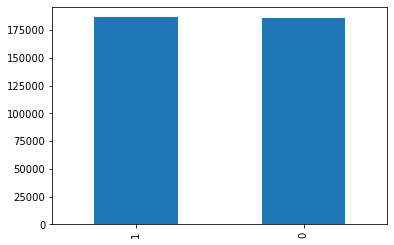

In [22]:
train['감정_int'].value_counts().plot(kind = 'bar')
print(train.groupby('감정_int').size().reset_index(name = 'count'))

   감정_int  count
0       0  20827
1       1  20572


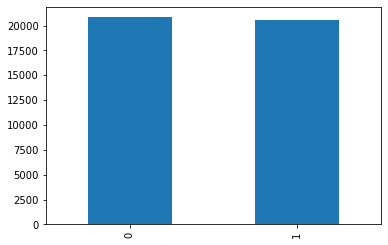

In [23]:
test['감정_int'].value_counts().plot(kind = 'bar')
print(test.groupby('감정_int').size().reset_index(name = 'count'))

In [24]:
train

,발화,감정_int
35888,시간이 아깝다...,0
120081,잘받아ㅏㅆ습니다 ㄴㅇ,1
125718,아직써보진안았는데 포장상태가 아니네요,0
147631,좋아요 아기때메 폰을ㅈ두고나두는일이 많았는데 줄이오고난후로는 매일들고 다니네요~~시...,1
164842,아직 안입어봤는데 괜찮을듯,1
...,...,...
8533,항상 응원하고 있습니다~~^^,1
152354,생각보다.. 설치를 못했어요ㅜㅜ 공간이작아여,0
3368,"재밌다. 깔끔하게 마무리되는 결말도 좋고,, 주변에 대해 아무런 신경도 쓰지않는 현...",1
112198,작은 나이롱 지퍼는 물론이고 바느질상태가 완전 허접합니다. 사이즈는 생각보다 작고 ...,0


In [25]:
train['발화'] = train['발화'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test['발화'] = test['발화'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

<ipython-input-25-2981e347a926>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train['발화'] = train['발화'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-25-2981e347a926>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['발화'] = train['발화'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-25-2981e347a926>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test['발화'] = test['발화'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-25-2981e347a926>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [26]:
train['발화'] = train['발화'].str.replace('^ +', "")
test['발화'] = test['발화'].str.replace('^ +', "")
train['발화'].replace('', np.nan, inplace = True)
test['발화'].replace('', np.nan, inplace = True)
print(train.isnull().sum())
print(test.isnull().sum())

<ipython-input-26-aa04aa4f771e>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train['발화'] = train['발화'].str.replace('^ +', "")
<ipython-input-26-aa04aa4f771e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['발화'] = train['발화'].str.replace('^ +', "")
<ipython-input-26-aa04aa4f771e>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test['발화'] = test['발화'].str.replace('^ +', "")


발화        1520
감정_int       0
dtype: int64
발화        166
감정_int      0
dtype: int64


<ipython-input-26-aa04aa4f771e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['발화'] = test['발화'].str.replace('^ +', "")
C:\Users\user\.conda\envs\gz\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [27]:
train.loc[train.발화.isnull()][:10]
test.loc[test.발화.isnull()][:10]
train = train.dropna(how='any')
test = test.dropna(how='any')
print(train.isnull().sum())
print(test.isnull().sum())
print('전처리 후 트레인용 샘플의 개수 :',len(train))
print('전처리 후 테스트용 샘플의 개수 :',len(test))

발화        0
감정_int    0
dtype: int64
발화        0
감정_int    0
dtype: int64
전처리 후 트레인용 샘플의 개수 : 371064
전처리 후 테스트용 샘플의 개수 : 41233


In [28]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [29]:
# 제대로 나누기

t_train = [] # 75%
t_test = [] # 25%
for sentence in train['발화']:
    temp_X = okt.morphs(sentence, stem = True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    t_train.append(temp_X)
    
for sentence in test['발화']:
    temp_X = okt.morphs(sentence, stem = True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    t_test.append(temp_X)

import nltk
nltk.download('punkt')
nltk.download('treebank')

from nltk.tokenize import word_tokenize
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import TreebankWordTokenizer

tb_tokenizer = TreebankWordTokenizer()

In [30]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(t_train)
tokenizer.fit_on_texts(t_test)

In [31]:
import pickle
 
## Save pickle
with open("finalsenti.pickle","wb") as fw:
    pickle.dump(tokenizer, fw)
 


In [32]:
threshold = 1
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt) * 100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq) * 100)

단어 집합(vocabulary)의 크기 : 75397
등장 빈도가 0번 이하인 희귀 단어의 수: 0
단어 집합에서 희귀 단어의 비율: 0.0
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.0


In [33]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 75398


# 빈도수 높은 단어 확인

# 알고리즘 수정 전 수정

In [34]:
train[:3]

,발화,감정_int
35888,시간이 아깝다,0
120081,잘받아ㅏㅆ습니다 ㄴㅇ,1
125718,아직써보진안았는데 포장상태가 아니네요,0


In [35]:
t_train1 = tokenizer.texts_to_sequences(t_train)
t_test1 = tokenizer.texts_to_sequences(t_test)

In [36]:
e_train = train['감정_int']
e_test = test['감정_int']

문장의 최대 길이 : 69
문장의 평균 길이 : 11.467458443826402


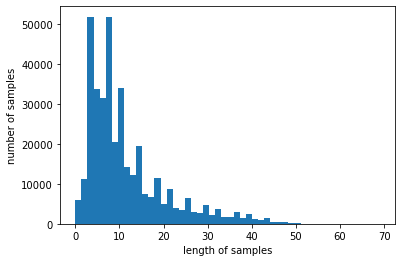

In [37]:
print('문장의 최대 길이 :',max(len(l) for l in t_train1))
print('문장의 평균 길이 :',sum(map(len, t_train1))/len(t_train1))
plt.hist([len(s) for s in t_train1], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [38]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [39]:
max_len = 42
below_threshold_len(max_len, t_train1)

전체 샘플 중 길이가 42 이하인 샘플의 비율: 99.18666321712696


In [40]:
t_train2 = pad_sequences(t_train1, maxlen = max_len)
# t_train11, t_train22 = tokenizer.texts_to_sequences
t_test2 = pad_sequences(t_test1, maxlen = max_len)

In [41]:
from keras import models
from tensorflow.keras.layers import Embedding, Dense, LSTM, GRU, Dropout
from tensorflow.keras.models import Sequential


from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [42]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128, return_sequences = True))
model.add(Dropout(0.5))
model.add(GRU(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('final.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='mse', metrics=['acc'])
history = model.fit(t_train2, e_train, epochs=15, callbacks=[es, mc], batch_size=6000, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         7539800   
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         117248    
_________________________________________________________________
dropout (Dropout)            (None, None, 128)         0         
_________________________________________________________________
gru (GRU)                    (None, 128)               99072     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 7,756,249
Trainable params: 7,756,249
Non-trainable params: 0
______________________________________________

In [44]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(t_test2, e_test)[1]))

InvalidArgumentError:  indices[12,29] = 71956 is not in [0, 46870)
	 [[node sequential_8/embedding_8/embedding_lookup (defined at <ipython-input-44-39342799c0af>:2) ]] [Op:__inference_test_function_11916]

Errors may have originated from an input operation.
Input Source operations connected to node sequential_8/embedding_8/embedding_lookup:
 sequential_8/embedding_8/embedding_lookup/11035 (defined at C:\Users\user\.conda\envs\gz\lib\contextlib.py:113)

Function call stack:
test_function


In [ ]:
loaded_model.summary()

In [ ]:
def sentiment_predict(new_sentence):
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    if(score > 0.8):
        print("{:.4f}행복합니다.\n".format(score))
    elif(score > 0.6) :
        print("{:.4f}약간 기분이 좋습니다.\n".format(score))
    elif(score > 0.4) :
        print("{:.4f}약간 기분이 안좋습니다.\n".format(score))
    elif(score > 0.2) :
        print("{:.4f}기분이 나쁩니다.\n".format(score))
    else:
        print("{:.4f}기분이 매우 나쁩니다.\n".format(score))

In [ ]:
sentiment_predict('뭐가 문제야')

In [ ]:
print('0에 가까우면 부정, 1에 가까우면 긍정\n')
sentiment_predict('아 진짜 짜증난다 이게 뭐냐 되는 일도 없고')

In [ ]:
print('0에 가까우면 부정, 1에 가까우면 긍정\n')
sentiment_predict('오늘 야근이라서')

In [ ]:
print('0에 가까우면 부정, 1에 가까우면 긍정\n')
sentiment_predict('오늘 데이트 어디서 할까??')

In [ ]:
print('0에 가까우면 부정, 1에 가까우면 긍정\n')
sentiment_predict('저희 조 망했어요')

In [ ]:
print('0에 가까우면 부정, 1에 가까우면 긍정\n')
sentiment_predict('오늘 집에 가서 뭐하지?')

In [ ]:
sentiment_predict('그래주면 좋겠는데 괜찮겠어?')

In [ ]:
sentiment_predict('이번주는 시험기간')

In [ ]:
sentiment_predict('축하축하')

In [ ]:
sentiment_predict('날도 좋은데 시원하게 맥주 한잔 콜?')

In [ ]:
sentiment_predict('이현지 최고~~~~')

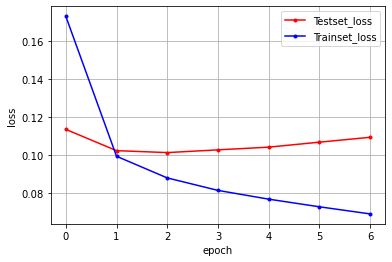

In [45]:
# 테스트 셋의 오차
y_vloss = history.history['val_loss']

# 학습셋의 오차
y_loss = history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
 # 테스트 셋의 오차
y_vloss = history.history['val_loss']

# 학습셋의 오차
y_loss = history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
 # 테스트 셋의 오차
y_vloss = history.history['val_loss']

# 학습셋의 오차
y_loss = history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()